In [1]:
#imports
from rundmcmc.chain import MarkovChain
from rundmcmc.make_graph import construct_graph, add_data_to_graph, get_assignment_dict
from rundmcmc.partition import Partition, propose_random_flip
from rundmcmc.updaters import statistic_factory, cut_edges
from rundmcmc.validity import Validator, fast_connected
import geopandas as gp
import networkx as nx
import numpy as np
import areal_interpolation as areal
import scipy.linalg
import scipy.stats
import matplotlib.pyplot as plt
import time
from IPython import display 
import pylab as pl
import matplotlib.animation as manimation
import os


In [2]:

# read the file and assign districts to vtds
df = gp.read_file("./testData/tl_2012_37_vtd10.shp")
df_cd =  gp.read_file('./testData/cd_us.shp')
df['dummy']=-1
df['temp'] = -1
(df,new_tar) = areal.aggregate(df,df_cd,['dummy'],['STATECD'])

In [3]:
# build the graph object
graph = construct_graph(df, geoid_col="GEOID10")
add_data_to_graph(df, graph, ['STATECD', 'ALAND10'], id_col='GEOID10')
assignment = get_assignment_dict(df, "GEOID10", "STATECD")
CDS = set([x for x in assignment.values()])

In [4]:
# precompute eigenvalues for things that won't change

lap = nx.normalized_laplacian_matrix(graph).todense()
st_eigs = np.real(scipy.linalg.eigvals(lap).tolist())
st_eigs.sort()

rem_gr = nx.from_numpy_matrix(scipy.sparse.load_npz(os.path.join('./testData/37_blocks12.npz')).todense())
rem_eigs = np.real(nx.normalized_laplacian_matrix(rem_gr)).todense()
rem_eigs = np.real(scipy.linalg.eigvals(rem_eigs).tolist())

rem_eigs.sort()

lap = nx.normalized_laplacian_matrix(graph).todense()
evals = np.real(scipy.linalg.eigvals(lap).tolist())
evals.sort()

In [5]:
# runs chain for <steps> iterations, drawing every <interval>
def main(steps, interval):
    # Sketch:
    #   1. Load dataframe.
    #   2. Construct neighbor information.
    #   3. Make a graph from this.
    #   4. Throw attributes into graph.
   
    tic = time.time()

    #plt.tight_layout()
    plt.sca(ax1)        


    increment  = (0. + interval)/steps
    validator = Validator([fast_connected])
    updaters = {'area': statistic_factory('ALAND10', alias='area'), 'cut_edges': cut_edges}

    initial_partition = Partition(graph, assignment, updaters)
    accept = lambda x: True

    chain = MarkovChain(propose_random_flip, validator, accept,
                        initial_partition, total_steps=steps)#2**15)
    
    plan_graph = nx.Graph()
    for cd in CDS:
        district = [k for k in chain.state.assignment.keys() if chain.state.assignment[k]==cd]

        dist_nodes = [x for x,y in graph.nodes(data=True) if x in district]

        dist_graph = graph.subgraph(dist_nodes)

        plan_graph = nx.union(plan_graph,dist_graph)

        for n in dist_graph.nodes(data=True):
            df.loc[df['GEOID10'] == n[0],'STATECD'] = cd    

    
        lap = nx.normalized_laplacian_matrix(plan_graph).todense()
        og_eigs = np.real(scipy.linalg.eigvals(lap).tolist())
        og_eigs.sort()   
    
        num_edges = np.sum(nx.to_numpy_matrix(graph))/2
        cut_in_orig = num_edges - (np.sum(nx.to_numpy_matrix(plan_graph)))/2
        cut_in_rem = num_edges - (np.sum(nx.to_numpy_matrix(rem_gr)))/2

    col = (1.,1.,0)
    c=0
    for step in chain:
        #if chain.counter%100 == 0: print("STEP "+ str(chain.counter))
        if chain.counter % interval == 1:
            print("ON STEP " + str(chain.counter))
            
            
            
            tic = time.time()
            plan_graph = nx.Graph()
            for cd in CDS:
                district = [k for k in chain.state.assignment.keys() if chain.state.assignment[k]==cd]

                dist_nodes = [x for x,y in graph.nodes(data=True) if x in district]

                dist_graph = graph.subgraph(dist_nodes)

                plan_graph = nx.union(plan_graph,dist_graph)

                for n in dist_graph.nodes(data=True):
                    df.loc[df['GEOID10'] == n[0],'STATECD'] = cd


            cut_in_curr = num_edges - (np.sum((nx.to_numpy_matrix(plan_graph))))/2
            #adj = nx.adjacency_matrix(plan_graph)

            #display.clear_output(wait=True)
            #display.display(pl.gcf())
            lap = nx.normalized_laplacian_matrix(plan_graph).todense()
            evals = np.real(scipy.linalg.eigvals(lap).tolist())
            evals.sort()
            plt.sca(ax1)
            plt.cla()
            ax1.set_ylim((-.02,.3))
            ax1.set_xlim((-1,200))
            plt.plot(range(len(rem_eigs[:200])),rem_eigs[:200]/cut_in_rem,color='g',label = '2012 Districts')
            plt.plot(range(len(og_eigs[:200])),og_eigs[:200]/cut_in_orig,color='b',label = 'CD115')
            plt.plot(range(len(st_eigs[:200])),st_eigs[:200],color='k',label = 'Whole State')
            

            
            
            plt.plot(range(len(evals[:200])),evals[:200]/cut_in_curr,color='r',label = 'Proposed Plan #%d' % chain.counter)
            ax1.legend(loc=2)
            col = (1.,col[1]-increment, col[2]+increment)

            plt.sca(ax2)
            display.clear_output(wait=True)
            display.display(pl.gcf())
            plt.cla()
            
            df.plot(column = 'STATECD',ax=ax2, cmap='tab20')
            #fig.savefig('imgs/nc_test_%05d.png' % c) # ucomment to save images

            c+=1

            
    print(time.time()-tic)
    

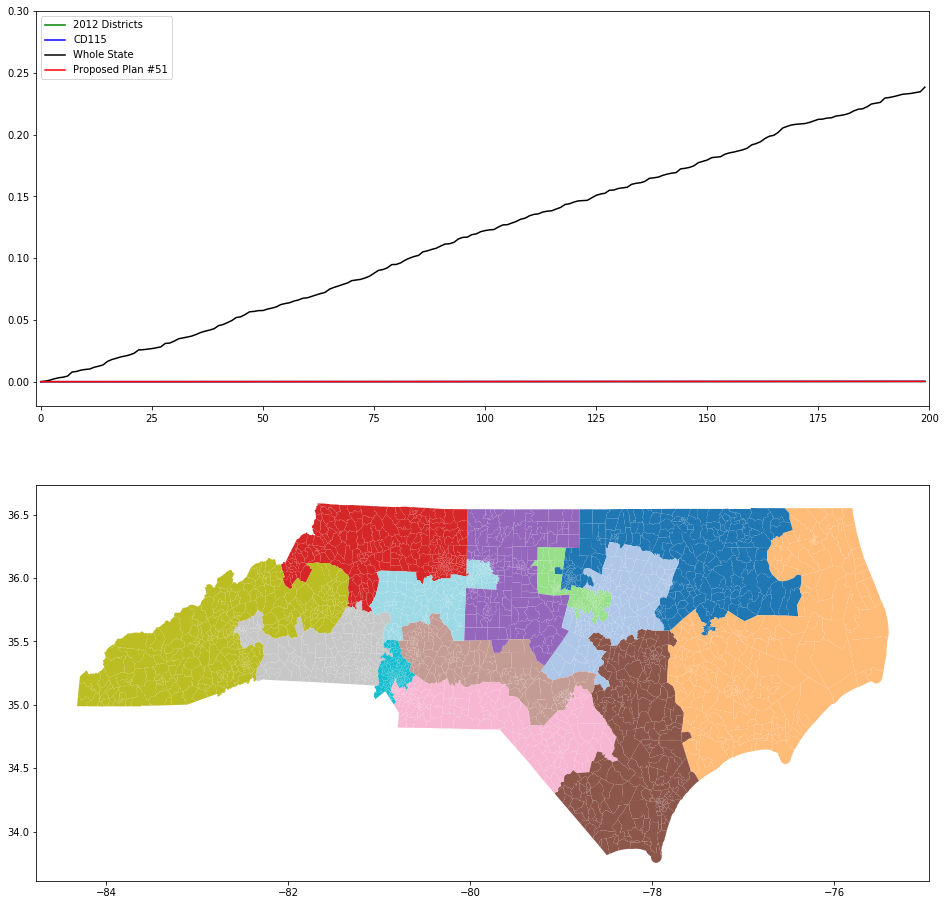

ON STEP 76


KeyboardInterrupt: 

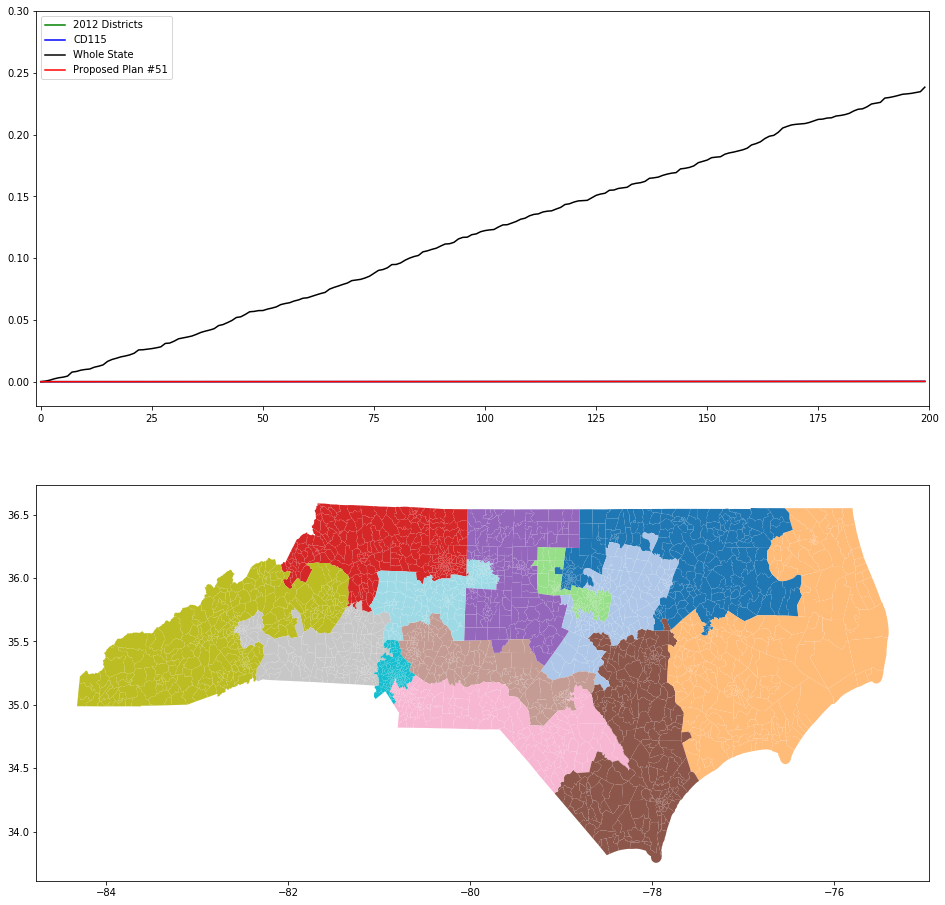

In [6]:
#make the figure, run the code
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,16))

main(25001,25)
